In [ ]:
# this code is used for connecting to Google Colabotory.
# If you run this file on your own local server,
# DON'T run this code chunk

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
# And don't run this code chunk
!mkdir -p drive
!google-drive-ocamlfuse drive -o nonempty

# Movie Recommender system
This is a group project of ISSS 610 Applied Machine Learning.  

Group Member: GENG Minghong, HUANG Lu, Manish Agarwal, TAO Xinru  

Project Timeline:

Time|Jobs
-----|-----
2020-03-21|Data Cleaning
2020-03-23|Exploring
**2020-03-30**|**Presentation**

# 0. Introduction 
The data of this project can be accessed here:  
https://smu.sharepoint.com/teams/ISSS610AppliedMachineLearning/Shared%20Documents/Forms/AllItems.aspx?viewid=1b247e4e%2D6a34%2D4c70%2D8abc%2D06cee2cccbea  

In [1]:
# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#使用pickle模块将数据对象保存到文件
import pickle
data1 = {'a': [1, 2.0, 3, 4+6j],
     'b': ('string', u'Unicode string'),
     'c': None}
 
selfref_list = [1, 2, 3]
selfref_list.append(selfref_list)
 
output = open('data.pkl', 'wb')
 
# Pickle dictionary using protocol 0.
pickle.dump(data1, output)
 
# Pickle the list using the highest protocol available.
pickle.dump(selfref_list, output, -1)
 
output.close()

In [3]:
#使用pickle模块从文件中重构python对象
import pprint, pickle
pkl_file = open('data.pkl', 'rb')
data1 = pickle.load(pkl_file)
pprint.pprint(data1)
data2 = pickle.load(pkl_file)
pprint.pprint(data2)
pkl_file.close()

{'a': [1, 2.0, 3, (4+6j)], 'b': ('string', 'Unicode string'), 'c': None}
[1, 2, 3, <Recursion on list with id=4427374496>]


# 1. Processing Data

## 1.1 Packages Used in This Project
The packages we used in this packages are:
- Pandas
- NumPy
- ...
- (To be fill)

## 1.2 Data Cleaning 


### 1.2.1 keywords.csv

In [4]:
import pandas as pd
from ast import literal_eval

keywords= pd.read_csv(r'data/themoviesdataset/keywords.csv')
keywords['keywordsTr'] = keywords['keywords'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
keywordsTr=keywords.drop(['keywords'],axis=1)

In [5]:
keywordsTr.rename(columns = {'id':'tmdb_id'},inplace=True)
keywordsTr['tmdb_id'] = keywordsTr['tmdb_id'].apply(str)

keywordsTr.head()

,tmdb_id,keywordsTr
0,862,"[jealousy, toy, boy, friendship, friends, riva..."
1,8844,"[board game, disappearance, based on children'..."
2,15602,"[fishing, best friend, duringcreditsstinger, o..."
3,31357,"[based on novel, interracial relationship, sin..."
4,11862,"[baby, midlife crisis, confidence, aging, daug..."


In [6]:
keywordsTr.to_csv('data/themoviesdataset/keywordsTr.csv',index=False)

### 1.2.2  rating.csv
We want to transform the time stamp into readable time format.   Reference:https://blog.csdn.net/weixin_43790560/article/details/88412005

In [8]:
rating= pd.read_csv(r'data/themoviesdataset/ratings.csv')
#rating['timestampTr']=pd.to_datetime(rating['timestamp'],unit='s')
ratingTr=rating[['userId','movieId','rating','timestamp']]

In [ ]:
#ratingTr.to_csv('ratingTr.csv')

In [9]:
ratingTr.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


**Then we need to decide what to keep in `timestampTr`. Day? Week? Month?**

### 1.2.3 credits.csv

In [10]:
import pandas as pd
import numpy as np
from ast import literal_eval

In [11]:
credits = pd.read_csv(r'data/themoviesdataset/credits.csv')
credits.head(2)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844


In [12]:
#Rename the id column and change the data type
credits.rename(columns = {'id':'tmdb_id'},inplace=True)
credits['tmdb_id'] = credits['tmdb_id'].apply(str)

# Parse the stringified features into their corresponding python objects
credits['cast'] = credits['cast'].apply(literal_eval)
credits['crew'] = credits['crew'].apply(literal_eval)
credits.head()

,cast,crew,tmdb_id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [13]:
# Define a function to get the director name
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

# Apply the function to get director name
credits['director'] = credits['crew'].apply(get_director)

In [14]:
# Returns the list top 3 elements or entire list; whichever is more.
credits['cast'] = credits['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
credits['cast'] = credits['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

# Drop the crew column
credits = credits.drop(['crew'], axis=1)

In [15]:
creditsTr = credits
creditsTr.head(2)

,cast,tmdb_id,director
0,"[Tom Hanks, Tim Allen, Don Rickles]",862,John Lasseter
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",8844,Joe Johnston


In [16]:
creditsTr.to_csv('data/themoviesdataset/creditsTr.csv',index=False)

### 1.2.4 movies_metadata.csv

In the origin dataset, 24 columns are provided. We only need 12 of them.

In [17]:
import pandas as pd
import numpy as np
from ast import literal_eval

#movies_metadata= pd.read_csv(r'/content/drive/data/themoviesdataset/movies_metadata.csv')
movies_metadata= pd.read_csv('data/themoviesdataset/movies_metadata.csv')

# select 12 variables from the movies_metadata dataset
movies_metadataTr = movies_metadata[['genres','id','imdb_id','overview','popularity','release_date',
                         'revenue','budget','runtime','status','title','vote_average','vote_count','poster_path']]

print(movies_metadataTr.shape)
movies_metadataTr.head(2)

(45466, 14)


,genres,id,imdb_id,overview,popularity,release_date,revenue,budget,runtime,status,title,vote_average,vote_count,poster_path
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,373554033.0,30000000,81.0,Released,Toy Story,7.7,5415.0,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,262797249.0,65000000,104.0,Released,Jumanji,6.9,2413.0,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg


In [18]:
movies_metadataTr['genres'] = movies_metadataTr['genres'].apply(literal_eval)
# Get the genres
movies_metadataTr['genres'] = movies_metadataTr['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# Rename the column id to tmdb_id
movies_metadataTr.rename(columns = {'id':'tmdb_id'},inplace=True)

In [19]:
movies_metadataTr.head(2)

,genres,tmdb_id,imdb_id,overview,popularity,release_date,revenue,budget,runtime,status,title,vote_average,vote_count,poster_path
0,"[Animation, Comedy, Family]",862,tt0114709,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,373554033.0,30000000,81.0,Released,Toy Story,7.7,5415.0,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg
1,"[Adventure, Fantasy, Family]",8844,tt0113497,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,262797249.0,65000000,104.0,Released,Jumanji,6.9,2413.0,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg


In [20]:
#movies_metadataTr.to_csv('/content/drive/data/movies_metadataTr.csv',index=False)
movies_metadataTr.to_csv('data/themoviesdataset/movies_metadataTr.csv',index=False)

## 1.3 Merge the data

### 1.3.1 Movie

Merge the `movies_metadataTr`, `creditsTr`, and `keywordsTr.csv`.

In [21]:
# Load the packages.
import pandas as pd

# And the files 
#movies_metadataTr = pd.read_csv('/content/drive/data/themoviesdataset/movies_metadataTr.csv')
#creditsTr = pd.read_csv('/content/drive/data/themoviesdataset/creditsTr.csv')
#keywordsTr = pd.read_csv('/content/drive/data/themoviesdataset/keywordsTr.csv')

# change the data type of 'tmdb_id'
movies_metadataTr['tmdb_id'] = movies_metadataTr['tmdb_id'].astype('category')
creditsTr['tmdb_id'] = creditsTr['tmdb_id'].astype('category')
keywordsTr['tmdb_id'] = keywordsTr['tmdb_id'].astype('category')

In [22]:
# Merge the movies_metadata.csv, credits.csv, and keywords.csv into a single dataframe.
metadataTr_creditsTr = pd.merge(movies_metadataTr, 
                   creditsTr, 
                   how = 'left', 
                   on = ['tmdb_id'])

metadataTr_creditsTr_keywordsTr = pd.merge(metadataTr_creditsTr, 
                       keywordsTr, 
                       how = 'left', 
                       on = ['tmdb_id'])
# see what we get
metadataTr_creditsTr_keywordsTr.head(2)

,genres,tmdb_id,imdb_id,overview,popularity,release_date,revenue,budget,runtime,status,title,vote_average,vote_count,poster_path,cast,director,keywordsTr
0,"[Animation, Comedy, Family]",862,tt0114709,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,373554033.0,30000000,81.0,Released,Toy Story,7.7,5415.0,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy, friendship, friends, riva..."
1,"[Adventure, Fantasy, Family]",8844,tt0113497,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,262797249.0,65000000,104.0,Released,Jumanji,6.9,2413.0,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[board game, disappearance, based on children'..."


In [23]:
# Select rows where the column status == 'Released'
data_movies = metadataTr_creditsTr_keywordsTr[metadataTr_creditsTr_keywordsTr['status'] == 'Released']

# turn off the warning
pd.options.mode.chained_assignment = None  # default='warn'

# (2020-03-27 22:25)
# This is an additional modification.
# Remove the quotes

data_movies['genres'] = data_movies['genres'].replace("'", "")
data_movies['cast'] = data_movies['cast'].replace("'", "")
data_movies['keywordsTr'] = data_movies['keywordsTr'].replace("'", "")

# Fill NA by the space
data_movies = data_movies.fillna(' ')

# see what we have
data_movies.head(2)

,genres,tmdb_id,imdb_id,overview,popularity,release_date,revenue,budget,runtime,status,title,vote_average,vote_count,poster_path,cast,director,keywordsTr
0,"[Animation, Comedy, Family]",862,tt0114709,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,373554033.0,30000000,81,Released,Toy Story,7.7,5415.0,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy, friendship, friends, riva..."
1,"[Adventure, Fantasy, Family]",8844,tt0113497,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,262797249.0,65000000,104,Released,Jumanji,6.9,2413.0,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[board game, disappearance, based on children'..."


In [24]:
def get_values(data_str):
    if isinstance(data_str, float):
        pass
    else:
        values = []
        data_str = ast.literal_eval(data_str)
        if isinstance(data_str, list):
            for k_v in data_str:
                values.append(k_v['name'])
            return values
        else:
            return None

In [25]:
def counting_values(df, column):
    value_count = {}
    for row in df[column].dropna():
        if len(row) > 0:
            for key in row:
                if key in value_count:
                    value_count[key] += 1
                else:
                    value_count[key] = 1
        else:
            pass
    return value_count

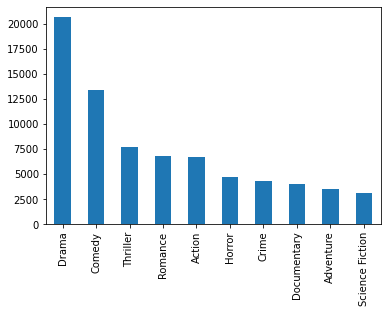

In [26]:
genres_count = pd.Series(counting_values(data_movies, 'genres'))
genres_count.sort_values(ascending = False).head(10).plot(kind = 'bar')

In [27]:
data_movies.to_csv('data/themoviesdataset/data_movies.csv',index=False)

`Genre`, `overview`, `Keywords` are very useful to calculate the similarity between movies.

### 1.3.2 User

In [29]:
tags = pd.read_csv('data/ml-25m/tags.csv')

In [30]:
tags.shape

(1093360, 4)

In [31]:
tags[tags['userId']==4]

,userId,movieId,tag,timestamp
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455
5,4,44665,unreliable narrators,1573943619
6,4,115569,tense,1573943077
7,4,115713,artificial intelligence,1573942979
8,4,115713,philosophical,1573943033
9,4,115713,tense,1573943042
10,4,148426,so bad it's good,1573942965
11,4,164909,cliche,1573943721


In [32]:
ratingTr[ratingTr['userId']==4]

,userId,movieId,rating,timestamp
59,4,223,4.0,1042668576
60,4,415,4.0,1042667925
61,4,648,4.0,1042674800
62,4,1097,5.0,1042667925
63,4,1197,4.0,1042667956
...,...,...,...,...
116,4,4226,3.0,1042674412
117,4,4238,4.0,1042674819
118,4,4848,3.0,1042674425
119,4,4896,4.0,1042667845


In [33]:
data_user = pd.merge(ratingTr, tags, how = 'left', on = ['userId','movieId','timestamp'])

In [34]:
data_user['tag'].value_counts()

Series([], Name: tag, dtype: int64)

In [ ]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


  ERROR: Could not find a version that satisfies the requirement scikit-surprise (from versions: none)
ERROR: No matching distribution found for scikit-surprise


# 2. EDA

In [35]:
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

## 2.1 Number of Movies

### 2.1.1 Number of Movies by the year


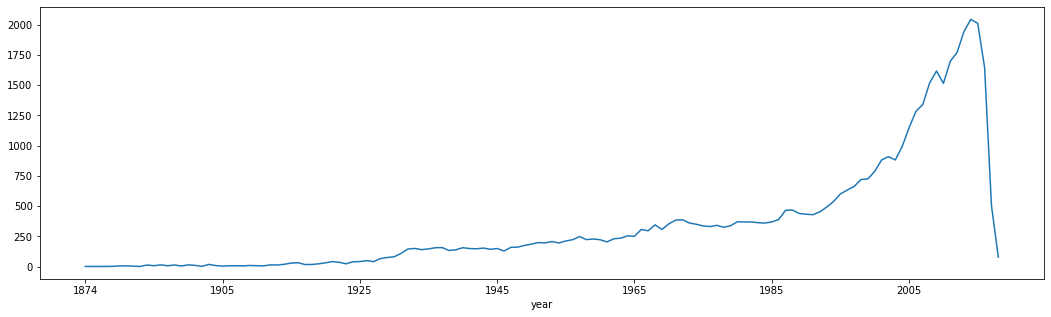

In [36]:
import pandas as pd
import numpy as np

data_movies = pd.read_csv('data/themoviesdataset/data_movies.csv')

# Create a new column to store the variable year
data_movies['year'] = pd.to_datetime(data_movies['release_date'], 
                            errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

year_count = data_movies.groupby('year')['tmdb_id'].count()
plt.figure(figsize=(18,5))
year_count.plot()

The Dataset of about 45,000 movies available to us does not represent the entire corpus of movies released since the inception of cinema. However, it is reasonable to assume that it does include almost every major film released in Hollywood as well as other major film industries across the world (such as Bollywood in India). 

It can be seen from the chart that there is a sharp rise in the number of movies **starting the 1990s decade**.

### 2.1.2 Movies released by the month

In [37]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [38]:
data_movies.shape

(46165, 18)

In [39]:
data_movies['month'] = data_movies['release_date'].apply(get_month)

data_movies['revenue'] = data_movies['revenue'].astype('float')
data_movies['budget'] = data_movies['budget'].astype('float')

data_movies['return'] = data_movies['revenue'] / data_movies['budget']

(-1.0, 25.0)

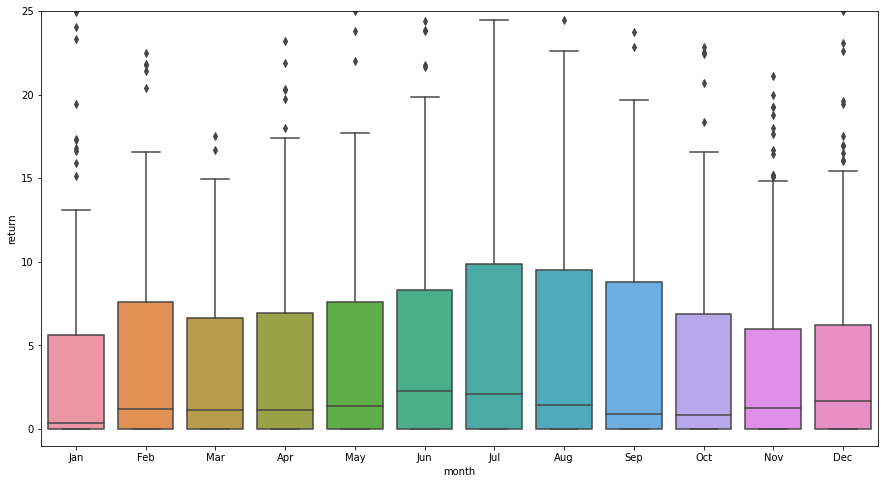

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='month', y='return', data=data_movies[data_movies['return'].notnull()], ax=ax, order=month_order)
ax.set_ylim([-1, 25])

**The months of June, July, and December tend to yield the highest median returns.** This can be attributed to the fact that blockbuster movies are usually released in the summer when the kids are out of school and the parents are on vacation and therefore, the audience is more likely to spend their disposable income on entertainment.

**January, September, and October are the least successful months on the aforementioned metrics**, which are the month of the school/college semester beginning, and hence a slight reduction in the consumption of movies.

## 2.2 Keywords and Genres

In [42]:
from wordcloud import WordCloud, STOPWORDS
import pandas as pd

data_movies = pd.read_csv('data/themoviesdataset/data_movies.csv')

stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    data = [i.replace("'", '') for i in data]
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=120,
        max_font_size=40, 
        scale=5,
        width=500, height=300,
        margin=2
    ).generate(str(data))

    fig = plt.figure(figsize=(10,7))
    plt.axis('off')
    
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust()
        
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.show()

In [43]:
data_movies['keywordsTr']

0        ['jealousy', 'toy', 'boy', 'friendship', 'frie...
1        ['board game', 'disappearance', "based on chil...
2        ['fishing', 'best friend', 'duringcreditssting...
3        ['based on novel', 'interracial relationship',...
4        ['baby', 'midlife crisis', 'confidence', 'agin...
                               ...                        
46160                                      ['tragic love']
46161                          ['artist', 'play', 'pinoy']
46162                                                   []
46163                                                   []
46164                                                   []
Name: keywordsTr, Length: 46165, dtype: object

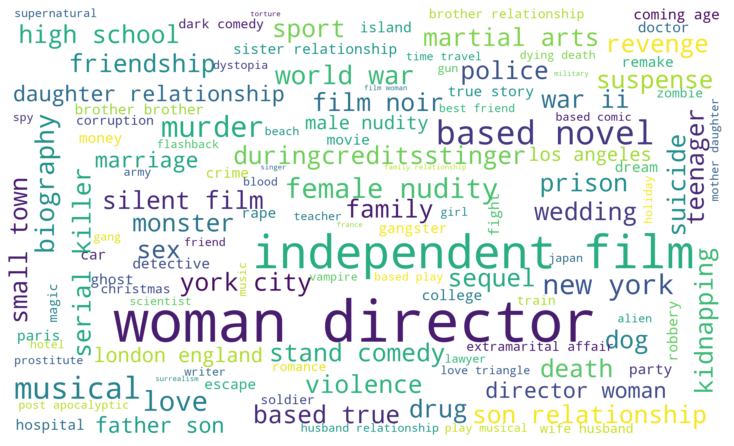

In [44]:
show_wordcloud(data_movies['keywordsTr'])

## 2.3 Popularity, Votes and Revenues


### 2.3.1 Most Popular Movies by Popularity Score

In [45]:
import pandas as pd

data_movies = pd.read_csv('data/themoviesdataset/data_movies.csv')
# Create a new column to store the variable year
data_movies['year'] = pd.to_datetime(data_movies['release_date'], 
                            errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
data_movies['popularity'].describe()

count    46165.000000
mean         2.912000
std          5.968457
min          0.000000
25%          0.387594
50%          1.127008
75%          3.662290
max        547.488298
Name: popularity, dtype: float64

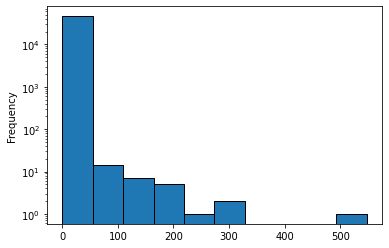

In [46]:
data_movies['popularity'].plot(logy=True, kind='hist', edgecolor='black')

The popularity seems to be an extremely skewed feature, with a mean of only **2.9** but maximum values reaching as high as **547**. However, as can be seen from the distribution plot, almost all movies have a popularity score less than 10 (the 75th percentile is at 3.678902).

In [47]:
data_movies[['title', 'popularity', 'year']].sort_values('popularity', ascending=False).head(10)

,title,popularity,year
30644,Minions,547.488298,2015
33268,Wonder Woman,294.337037,2017
42981,Beauty and the Beast,287.253654,2017
44377,Baby Driver,228.032744,2017
24439,Big Hero 6,213.849907,2014
26551,Deadpool,187.860492,2016
26552,Guardians of the Galaxy Vol. 2,185.330992,2017
14577,Avatar,185.070892,2009
24337,John Wick,183.870374,2014
23666,Gone Girl,154.801009,2014


**Minions** is the most popular movie and the value of `popularity` is much ahead of the second.

### 2.3.2 Most Voted on Movies

count    46165.000000
mean       109.150070
std        488.734401
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64


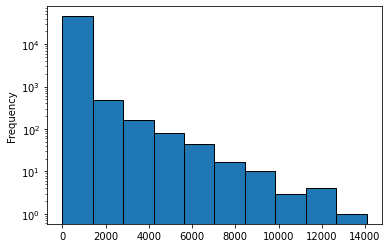

In [48]:
print(data_movies['vote_count'].describe())
data_movies['vote_count'].plot(logy=True, kind='hist', edgecolor='black')

In [49]:
data_movies[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).head(10)

,title,vote_count,year
15504,Inception,14075.0,2010
12485,The Dark Knight,12269.0,2008
14577,Avatar,12114.0,2009
17836,The Avengers,12000.0,2012
26551,Deadpool,11444.0,2016
22871,Interstellar,11187.0,2014
20050,Django Unchained,10297.0,2012
23742,Guardians of the Galaxy,10014.0,2014
2845,Fight Club,9678.0,1999
18252,The Hunger Games,9634.0,2012


**Inception** and **The Dark Knight**, two critically acclaimed and commercially successful *Christopher Nolan* movies figure at the top of our chart.

In [50]:
data_movies['vote_average'] = data_movies['vote_average'].replace(0, np.nan)
data_movies['vote_average'].describe()

count    43112.000000
mean         6.014764
std          1.253522
min          0.500000
25%          5.300000
50%          6.100000
75%          6.800000
max         10.000000
Name: vote_average, dtype: float64

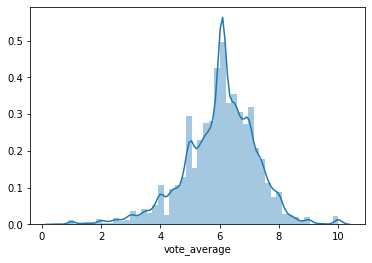

In [51]:
sns.distplot(data_movies['vote_average'].fillna(data_movies['vote_average'].median()))

It appears that these movie viewers are extremely strict in their ratings. **The mean vote is only a 6 on a scale of 10.** Almost half the movies have a rating of less than or equal to 6. In general, the `vote_average` is normally distributed.

### 2.3.3 Most Critically Acclaimed Movies

Only consider movies where `vote_count` is greater than 2500 to find out the most acclaimed movies.

In [52]:
data_movies[data_movies['vote_count'] > 2500][['title', 'vote_average', 'vote_count' ,'year']].sort_values('vote_average',ascending=False).head(10)

,title,vote_average,vote_count,year
313,The Shawshank Redemption,8.5,8358.0,1994
833,The Godfather,8.5,6024.0,1972
2845,Fight Club,8.3,9678.0,1999
12485,The Dark Knight,8.3,12269.0,2008
23664,Whiplash,8.3,4376.0,2014
1182,The Godfather: Part II,8.3,3418.0,1974
521,Schindler's List,8.3,4436.0,1993
5480,Spirited Away,8.3,3968.0,2001
1156,One Flew Over the Cuckoo's Nest,8.3,3001.0,1975
291,Pulp Fiction,8.3,8670.0,1994


**The Shawshank Redemption** and **The Godfather** are the two most critically acclaimed movies in the TMDB Database, and they are also common on other top rating lists.

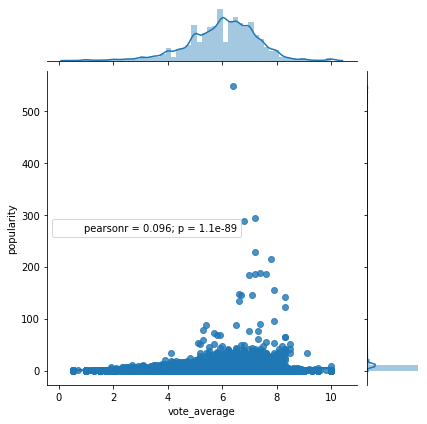

In [53]:
sns.jointplot(x='vote_average', y='popularity', data=data_movies, kind="reg").annotate(stats.pearsonr)

However, it is surprising that there is almost no correlation between `popularity` and `vote_average` from the **Pearsonr Correlation 0.096**.

### 2.3.4 Highest Grossing Films of All Time

In [54]:
data_movies.head(2)

,genres,tmdb_id,imdb_id,overview,popularity,release_date,revenue,budget,runtime,status,title,vote_average,vote_count,poster_path,cast,director,keywordsTr,year
0,"['Animation', 'Comedy', 'Family']",862,tt0114709,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,30000000,81.0,Released,Toy Story,7.7,5415.0,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"['Tom Hanks', 'Tim Allen', 'Don Rickles']",John Lasseter,"['jealousy', 'toy', 'boy', 'friendship', 'frie...",1995
1,"['Adventure', 'Fantasy', 'Family']",8844,tt0113497,When siblings Judy and Peter discover an encha...,17.015539,1995-12-15,262797249.0,65000000,104.0,Released,Jumanji,6.9,2413.0,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"['Robin Williams', 'Jonathan Hyde', 'Kirsten D...",Joe Johnston,"['board game', 'disappearance', ""based on chil...",1995


In [55]:
from IPython.display import Image, HTML
# Load poster from the TMDB website
base_poster_url = 'http://image.tmdb.org/t/p/w185/'
data_movies['poster_path'] = "<img src='" + base_poster_url + data_movies['poster_path'] + "' style='height:100px;'>"

gross_top = data_movies[['poster_path', 'title', 'revenue', 'year']].sort_values('revenue', ascending=False).head(6)
pd.set_option('display.max_colwidth', 100)
HTML(gross_top.to_html(escape=False))

,poster_path,title,revenue,year
14577,,Avatar,2.787965e+09,2009
26544,,Star Wars: The Force Awakens,2.068224e+09,2015
1642,,Titanic,1.845034e+09,1997
17836,,The Avengers,1.519558e+09,2012
25068,,Jurassic World,1.513529e+09,2015
28794,,Furious 7,1.506249e+09,2015


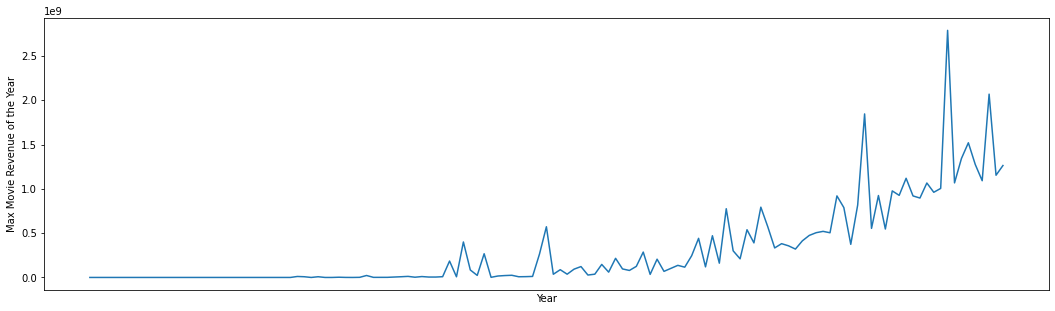

In [57]:
plt.figure(figsize=(18,5))
year_revenue = data_movies[(data_movies['revenue'].notnull()) & (data_movies['year'] != 'NaT')].groupby('year')['revenue'].max()
plt.plot(year_revenue.index, year_revenue)
plt.xticks(np.arange(1874, 2024, 10.0))
plt.autoscale()
plt.ylabel('Max Movie Revenue of the Year')
plt.xlabel('Year')
plt.show()

As can be seen from the figure, the maximum gross has steadily risen over the years. The world of movies broke the 1 billion dollar mark in 1997 with the release of **Titanic**. It took another 12 years to break the 2 billion dollar mark with **Avatar**. Both these movies were directed by **James Cameron**.

# 3. Model Building
Basiclly there are 3 kinds of recommendation system:

- Demographic Filtering: They offer generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. Since each user is different , this approach is considered to be too simple. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.
- Content Based Filtering: They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.
- Collaborative Filtering: This system matches persons with similar interests and provides recommendations based on this matching. Collaborative filters do not require item metadata like its content-based counterparts.

Reference: [Getting start with a movie recommendation system](https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system)

## 2.1 Content Based Filtering System
When recommending a movie to a certain user, the first intuitive idea is to find the movies which are similar to the movies that the user previous watched. The fundation of this concept is that if one user has watched a movie before, it is very possible he/she watch this movie for his/her own interest.  

In another word, at this step, we **assume** that the movies that a user watchs are the movies that this user likes, or at ieast, are the movies his/her interested in. 

Hence, we need to choose an apporite method to calculate the similiarity between movies.  

Here, we try to bulid a *content base system*.

In a content base system, we **assume** the content of the movies is a very good summary of the movies and truly reflects the core of the movies.  

In this system, we use following variables as the component of the **content**s of movies.

- `overview`
- `cast`
- `crew` 
- `keyword` 
- `tagline` 
- ...

These variables are used to find its similarity between movies. Then the movies that are most likely to be similar are recommended.  

There are many measurements to calculate the similarity between contents. For now there are no prevailing metrics that are definitively better or best. 

measurement|review
-----------|------------------
dot product|The fastest algorithm
Cosine Similarity| Widely used

This project mainly uses **cosine similarity**.


### 2.1.1 Plot description based Recommender
Here we try to calculate the similarity between movies based on the **overview** of movies.  
We will compute pairwise similarity scores for all movies based on their `plot` descriptions and recommend movies based on that **similarity score**. The plot description is given in the `overview feature` of our dataset. Let's take a look at the data.

In [59]:
movies_metadataTr=pd.read_csv('data/themoviesdataset/movies_metadataTr.csv')

In [60]:
movies_metadataTr.head(2)

,genres,tmdb_id,imdb_id,overview,popularity,release_date,revenue,budget,runtime,status,title,vote_average,vote_count,poster_path
0,"['Animation', 'Comedy', 'Family']",862,tt0114709,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear o...",21.946943,1995-10-30,373554033.0,30000000,81.0,Released,Toy Story,7.7,5415.0,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg
1,"['Adventure', 'Fantasy', 'Family']",8844,tt0113497,When siblings Judy and Peter discover an enchanted board game that opens the door to a magical w...,17.015539,1995-12-15,262797249.0,65000000,104.0,Released,Jumanji,6.9,2413.0,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg


Analysing the `overview` column is a process of **text analysis**. We need to transform the `overview` of each movies to a matrix for further analysis.  
Two forms of matrix are aviliable: 
- Count
- Term Frequency-Inverse Document Frequency (TF-IDF)

In this project, **TD-IDF** is used. TD-IDF can help us reduce the weight of high frequency words in the matrix and thus help us to balance the matrix.  
The output of TF-IDF is a matrix of which:
- each row represents an overview of a movie.
- each column represents a term ( words that at least appears once in all the overviews)

 To achieve a good model, we need to do
- Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
- All stopwords are removed.
- Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.
- Words are stemmed — words are reduced to their root form.

Belowing is the way how we transfrom `overview` into matrix.

In [61]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2020)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/manishagarwal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Here we define a function `lemmatize_stemming()`, which is used to lemmatize and stem `overview`.

In [62]:
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 0:
            result.append(lemmatize_stemming(token))
    return result

In [64]:
overview=pd.DataFrame()
overview[['tmdb_id','overview_origin']] = movies_metadataTr[['tmdb_id','overview']]

overview['overview_processed'] = overview['overview_origin'].fillna('').astype(str).map(preprocess)
#documents['content'].fillna('').astype(str).map(preprocess)
overview['overview_processed'] = overview['overview_processed'].apply(', '.join)

overview = overview.drop(columns=['overview_origin'])

overview.head()

# save the dataframe into .csv file for later use.

overview.to_csv('data/themoviesdataset/overview.csv',index=False)

#### 2.1.1.1 Use overview as plot

In [ ]:
# save the dataframe into .csv file for later use.
#overview.to_csv('data/overview.csv',index=False)

In [65]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

# import the file. To save time.
overview = pd.read_csv('data/themoviesdataset/overview.csv')
overview['overview_processed'] = overview['overview_processed'].fillna('').astype(str)

# create TF-IDF matrix:
tfidf = TfidfVectorizer(#min_df=0.01, 
             max_df = 0.5, 
             stop_words = 'english')
tfidf_overview = tfidf.fit_transform(overview['overview_processed'])

In [66]:
tfidf_overview

<45466x55625 sparse matrix of type '<class 'numpy.float64'>'
	with 1148986 stored elements in Compressed Sparse Row format>

In [67]:
# Compute the cosine similarity matrix
#tfidf_overview_csr = sparse.csr_matrix(tfidf_overview).astype(np.float16)

#cosine_similiarity = cosine_similarity(tfidf_overview_csr)
#cosine_similiarity.shape


# this is another way to calculate the similiarity
from sklearn.metrics.pairwise import linear_kernel
# Compute the cosine similarity matrix
tfidf_overview = tfidf_overview.astype(np.float32)
cosine_sim = linear_kernel(tfidf_overview,tfidf_overview)

In [68]:
cosine_sim

array([[0.99999994, 0.02134756, 0.        , ..., 0.        , 0.00641567,
        0.        ],
       [0.02134756, 0.9999999 , 0.04065556, ..., 0.        , 0.02878305,
        0.00905906],
       [0.        , 0.04065556, 0.99999994, ..., 0.        , 0.01433483,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.00641567, 0.02878305, 0.01433483, ..., 0.        , 0.99999994,
        0.01120984],
       [0.        , 0.00905906, 0.        , ..., 0.        , 0.01120984,
        0.9999999 ]], dtype=float32)

We see that 456 different words were used to describe the 45466 movies in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the cosine similarity scores. There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:  
![cosine_similiarity](\pic\cosine_similiarity.png)  
Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.


We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [69]:
#Construct a reverse map of indices and movie titles
movies_metadata = pd.read_csv('data/themoviesdataset/movies_metadataTr.csv')
indices = pd.Series(movies_metadata.index, index=movies_metadata['title']).drop_duplicates()

We are now in a good position to define our recommendation function. These are the following steps we'll follow :-

Get the index of the movie given its title.
Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
Return the titles corresponding to the indices of the top elements.

In [70]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies_metadata['title'].iloc[movie_indices]

In [71]:
get_recommendations('The Dark Knight Rises')

12481                                       The Dark Knight
150                                          Batman Forever
1328                                         Batman Returns
15511                            Batman: Under the Red Hood
585                                                  Batman
21194    Batman Unmasked: The Psychology of the Dark Knight
9230                     Batman Beyond: Return of the Joker
19792               Batman: The Dark Knight Returns, Part 1
3095                           Batman: Mask of the Phantasm
18035                                      Batman: Year One
Name: title, dtype: object

While our system has done a decent job of finding movies with similar plot descriptions, the quality of recommendations is not that great. "The Dark Knight Rises" returns all Batman movies while it is more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by the present system.

#### 2.1.1.2 use keywords of overview

I discovered a nice feature within the nltk package that allows us to extract the key words from a text, and it even assigns scores to each word. I did not really consider the scores for this basic recommender, however I used this Rake function to extract key words from the Plot column, so instead of using the entire sentences describing the plot, I only considered the most relevant words in the description. In order to do this, I applied this function to each row under the Plot column and assigned the list of key words to a new column, named Key_words

link:https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243

In [73]:
# import the file. To save time.
overview = pd.read_csv('data/themoviesdataset/overview.csv')
overview['overview_processed'] = overview['overview_processed'].fillna('').astype(str)

In [74]:
overview.head(2)

,tmdb_id,overview_processed
0,862,"lead, woodi, andi, toy, live, happili, room, andi, birthday, bring, buzz, lightyear, scene, afra..."
1,8844,"sibl, judi, peter, discov, enchant, board, game, open, door, magic, world, unwit, invit, alan, a..."


In [76]:
#!pip install rake_nltk
from rake_nltk import Rake

# initializing the new column
overview['overview_keywords'] = ""

for index, row in overview.iterrows():# Iterate over DataFrame rows as (index, Series) pairs.
                  # 迭代表格
    overview_processed = row['overview_processed']
    
    # instantiating Rake, by default it uses english stopwords from NLTK
    # and discards all puntuation characters as well
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(overview_processed)

    # getting the dictionary whith key words as keys and their scores as values
    key_words_dict_scores = r.get_word_degrees()
    
    # assigning the key words to the new column for the corresponding movie
    row['overview_keywords'] = list(key_words_dict_scores.keys())

# dropping the Plot column
overview.drop(columns = ['overview_processed'], inplace = True)



In [77]:
#Now we can see the new columns of keywords of movies
overview.head(3)

,tmdb_id,overview_keywords
0,862,"[separ, asid, plot, owner, room, place, eventu, bring, lead, happili, scene, afraid, lose, andi,..."
1,8844,"[hope, magic, monkey, room, creatur, door, terrifi, prove, judi, unwit, riski, open, freedom, rh..."
2,15602,"[scare, fish, shop, time, local, neighbor, cook, italian, door, feud, wed, alarm, divorcé, worri..."


In [78]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

# create TF-IDF matrix:
tfidf = TfidfVectorizer(#min_df=0.01, 
             max_df = 0.5, 
             stop_words = 'english')
overview['overview_keywords'] = overview['overview_keywords'].apply(', '.join)
tfidf_overview_keywords = tfidf.fit_transform(overview['overview_keywords'])

In [79]:
tfidf_overview

<45466x55625 sparse matrix of type '<class 'numpy.float32'>'
	with 1148986 stored elements in Compressed Sparse Row format>

In [80]:
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
#tfidf_overview = tfidf_overview.astype(np.float32)
cosine_sim = linear_kernel(tfidf_overview,tfidf_overview)

In [81]:
cosine_sim

array([[0.99999994, 0.02134756, 0.        , ..., 0.        , 0.00641567,
        0.        ],
       [0.02134756, 0.9999999 , 0.04065556, ..., 0.        , 0.02878305,
        0.00905906],
       [0.        , 0.04065556, 0.99999994, ..., 0.        , 0.01433483,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.00641567, 0.02878305, 0.01433483, ..., 0.        , 0.99999994,
        0.01120984],
       [0.        , 0.00905906, 0.        , ..., 0.        , 0.01120984,
        0.9999999 ]], dtype=float32)

In [82]:
### ***后续改进：通过名字查找会出现重复，通过输入tmdbid来锁定电影。
movies_metadata = pd.read_csv('data/themoviesdataset/movies_metadataTr.csv')
indices = pd.Series(movies_metadata.index, index=movies_metadata['title']).drop_duplicates()

# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title

    idx = indices[title] 

    # Get the pairwsie similarity scores of all movies with that movie
    # 返回所有其他的电影与输入电影的相似程度。
    # index 150 为batman forever
    sim_scores = list(enumerate(cosine_sim[idx])) 
                             

    # Sort the movies based on the similarity scores
    # 相似性降序排列，最大的相似度的电影编号18252，score有0.2762
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies_metadata['title'].iloc[movie_indices]

In [85]:
get_recommendations('The Dark Knight Rises')
#get_recommendations('The Avengers') #有重名，无法返回列表。

12481                                       The Dark Knight
150                                          Batman Forever
1328                                         Batman Returns
15511                            Batman: Under the Red Hood
585                                                  Batman
21194    Batman Unmasked: The Psychology of the Dark Knight
9230                     Batman Beyond: Return of the Joker
19792               Batman: The Dark Knight Returns, Part 1
3095                           Batman: Mask of the Phantasm
18035                                      Batman: Year One
Name: title, dtype: object

### 2.1.2 Credits, Genres and Keywords Based Recommender

In [ ]:
from ast import literal_eval
import pandas as pd
data_movies = pd.read_csv('data/themoviesdataset/data_movies.csv')
#features = ['cast', 'director', 'keywordsTr', 'genres']

data_movies['cast'] = data_movies['cast'].apply(lambda x: literal_eval(str(x)))
data_movies['director'] = data_movies['director'].apply(lambda x: literal_eval(str(x)))
data_movies['keywordsTr'] = data_movies['keywordsTr'].apply(lambda x: literal_eval(str(x)))
data_movies['genres'] = data_movies['genres'].apply(lambda x: literal_eval(str(x)))
#for feature in features:
    #data_movies[feature] = data_movies[feature].fillna('').astype(str)
    #data_movies[feature] = data_movies[feature].apply(literal_eval)

In [95]:
# Function to convert all strings to lower case
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x)
        else:
            return ''

In [97]:
# Apply clean_data function to your features.
import pandas as pd

features = ['cast', 'keywordsTr', 'director', 'genres']
data_movies = pd.read_csv('data/themoviesdataset/data_movies.csv')

for feature in features:
    data_movies[feature] = data_movies[feature].apply(clean_data)

In [98]:
data_movies.head(2)

,genres,tmdb_id,imdb_id,overview,popularity,release_date,revenue,budget,runtime,status,title,vote_average,vote_count,poster_path,cast,director,keywordsTr
0,"['animation', 'comedy', 'family']",862,tt0114709,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear o...",21.946943,1995-10-30,373554033.0,30000000,81.0,Released,Toy Story,7.7,5415.0,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"['tom hanks', 'tim allen', 'don rickles']",john lasseter,"['jealousy', 'toy', 'boy', 'friendship', 'friends', 'rivalry', 'boy next door', 'new toy', 'toy ..."
1,"['adventure', 'fantasy', 'family']",8844,tt0113497,When siblings Judy and Peter discover an enchanted board game that opens the door to a magical w...,17.015539,1995-12-15,262797249.0,65000000,104.0,Released,Jumanji,6.9,2413.0,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"['robin williams', 'jonathan hyde', 'kirsten dunst']",joe johnston,"['board game', 'disappearance', ""based on children's book"", 'new home', 'recluse', 'giant insect']"


In [99]:
# Create a string that contains all the metadata which feeds to vectorizer
def create_pool(x):
    return ''.join(x['keywordsTr']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

data_movies['pool'] = data_movies.apply(create_pool, axis=1)
data_movies['pool'].head(5)

0    ['jealousy', 'toy', 'boy', 'friendship', 'friends', 'rivalry', 'boy next door', 'new toy', 'toy ...
1    ['board game', 'disappearance', "based on children's book", 'new home', 'recluse', 'giant insect...
2    ['fishing', 'best friend', 'duringcreditsstinger', 'old men'] [ ' w a l t e r   m a t t h a u ' ...
3    ['based on novel', 'interracial relationship', 'single mother', 'divorce', 'chick flick'] [ ' w ...
4    ['baby', 'midlife crisis', 'confidence', 'aging', 'daughter', 'mother daughter relationship', 'p...
Name: pool, dtype: object

In [100]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(data_movies['pool'])

In [101]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [102]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(data_movies.index, index=data_movies['title']).drop_duplicates()

In [103]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return data_movies['title'].iloc[movie_indices]

In [104]:
# Reset index of our main DataFrame and construct reverse mapping as before
data_movies = data_movies.reset_index()
indices = pd.Series(data_movies.index, index = data_movies['title'])

In [105]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

12485               The Dark Knight
10122                 Batman Begins
584                          Batman
1496                 Batman & Robin
1332                 Batman Returns
42745         DC Showcase: Catwoman
21416                    Kick-Ass 2
15535    Batman: Under the Red Hood
30488                 Suicide Squad
5052                  Hero at Large
Name: title, dtype: object

In [106]:
get_recommendations('Toy Story', cosine_sim2)

1813                                      Small Soldiers
15372                                        Toy Story 3
25779                         Toy Story That Time Forgot
1885                                      Child's Play 2
7554                                               Dolls
1884                                        Child's Play
3880                         The Transformers: The Movie
19114                                                Ted
2998                                         Toy Story 2
37304    The Tangerine Bear: Home in Time for Christmas!
Name: title, dtype: object

## 2.2 Collaborative Filtering

Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers. It is basically of two types:-

User based filtering- These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity. This filtering technique can be illustrated with an example. In the following matrixes, each row represents a user, while the columns correspond to different movies except the last one which records the similarity between that user and the target user. Each cell represents the rating that the user gives to that movie. Assume user E is the target.

### 2.2.1 Content based collaborative filtering(item based and user-based)

In [108]:
from datetime import datetime
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

reader = Reader()
ratings = pd.read_csv('data/themoviesdataset/ratings_small.csv')
#ratings = pd.read_csv('data/themoviesdataset/ratings_small.csv')
ratings['timestamp'] = ratings['timestamp'].apply( lambda x: datetime.fromtimestamp(x).date())
ratings.rename(columns = {'movieId':'tmdb_id'},inplace=True)
ratings.head()

,userId,tmdb_id,rating,timestamp
0,1,31,2.5,2009-12-14
1,1,1029,3.0,2009-12-14
2,1,1061,3.0,2009-12-14
3,1,1129,2.0,2009-12-14
4,1,1172,4.0,2009-12-14


In [114]:
user_id_movie = ratings.groupby('userId').count().tmdb_id

<function matplotlib.pyplot.show(*args, **kw)>

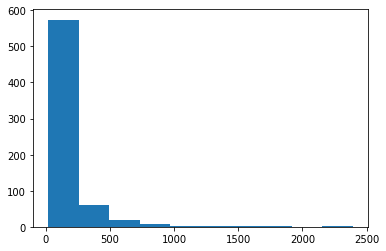

In [115]:
import matplotlib.pyplot as plt
plt.hist(user_id_movie.values)
plt.show

In [116]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(ratings['tmdb_id'])
ratings['id_trans'] = le.transform(ratings['tmdb_id'])

In [117]:
ratings.head()

,userId,tmdb_id,rating,timestamp,id_trans
0,1,31,2.5,2009-12-14,30
1,1,1029,3.0,2009-12-14,833
2,1,1061,3.0,2009-12-14,859
3,1,1129,2.0,2009-12-14,906
4,1,1172,4.0,2009-12-14,931


In [118]:
n_users = ratings.userId.nunique()
n_users

671

In [119]:
n_movies = ratings.tmdb_id.nunique()
n_movies

9066

In [120]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(ratings, test_size=0.3)

In [197]:
train_data

,userId,tmdb_id,rating,timestamp,id_trans
75687,525,4306,5.0,2002-06-24,3419
8597,56,56367,5.0,2016-06-27,6824
31921,232,1374,3.0,2000-04-07,1114
23872,169,1197,4.0,2009-02-10,954
85659,575,915,4.0,2002-04-06,736
...,...,...,...,...,...
18523,121,339,3.0,1996-05-26,304
44739,313,2394,5.0,2005-08-16,1904
40259,294,619,3.5,2003-08-22,545
61832,452,1752,2.0,2000-12-10,1377


In [198]:
test_data

,userId,tmdb_id,rating,timestamp,id_trans
37518,270,4308,3.0,2016-07-23,3420
99000,664,7445,4.5,2012-07-31,5144
70606,492,681,3.0,1998-06-18,581
72993,509,3978,3.0,2002-11-21,3183
71303,500,4973,4.5,2009-09-27,3854
...,...,...,...,...,...
32047,232,2145,4.0,2000-04-07,1703
65986,468,1610,2.5,2011-01-28,1281
24787,178,1302,2.5,2015-07-21,1055
82416,562,11,4.0,2006-12-30,10


In [121]:
train_data_matrix = np.zeros((n_users, n_movies))

train_data_matrix.shape

(671, 9066)

In [122]:
for line in train_data.itertuples():
    train_data_matrix[line[1] - 1, line[5]] = line[3]

In [123]:
test_data_matrix = np.zeros((n_users, n_movies))
for line in test_data.itertuples():
    test_data_matrix[line[1] - 1, line[5]] = line[3]

In [124]:
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(671, 9066)
(671, 9066)


In [125]:
train_data_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [126]:
from sklearn.metrics.pairwise import pairwise_distances

In [127]:
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')

In [128]:
movie_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [130]:
print(u"User similarity matrix：", user_similarity.shape, u"Item similarity matrix：", movie_similarity.shape)

User similarity matrix： (671, 671) Item similarity matrix： (9066, 9066)


In [131]:
print(user_similarity)

[[0.         1.         1.         ... 1.         1.         1.        ]
 [1.         0.         0.92768556 ... 0.99119015 0.81051562 0.93183355]
 [1.         0.92768556 0.         ... 0.91322676 0.91766144 0.84648012]
 ...
 [1.         0.99119015 0.91322676 ... 0.         0.94662965 0.96779384]
 [1.         0.81051562 0.91766144 ... 0.94662965 0.         0.89010077]
 [1.         0.93183355 0.84648012 ... 0.96779384 0.89010077 0.        ]]


In [133]:
print(movie_similarity)

[[0.         0.71361587 0.78719825 ... 1.         1.         0.93286896]
 [0.71361587 0.         0.81446775 ... 1.         1.         1.        ]
 [0.78719825 0.81446775 0.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 0.         0.         1.        ]
 [1.         1.         1.         ... 0.         0.         1.        ]
 [0.93286896 1.         1.         ... 1.         1.         0.        ]]


In [134]:
user_similarity_triu = np.triu(user_similarity,k=1) #上三角矩阵
user_similarity_triu

array([[0.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.92768556, ..., 0.99119015, 0.81051562,
        0.93183355],
       [0.        , 0.        , 0.        , ..., 0.91322676, 0.91766144,
        0.84648012],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.94662965,
        0.96779384],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.89010077],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [135]:
item_sim_nonzero2 = np.round(user_similarity_triu[
            user_similarity_triu.nonzero()
            ],3)
item_sim_nonzero2

array([1.   , 1.   , 0.933, ..., 0.947, 0.968, 0.89 ])

In [136]:
np.percentile(item_sim_nonzero2,np.arange(0,101,10))

array([0.332, 0.844, 0.886, 0.912, 0.932, 0.948, 0.963, 0.977, 1.   ,
       1.   , 1.   ])

In [137]:
def predict(ratings, similarity, type):
    # 基于用户相似度矩阵的
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = ( ratings - mean_user_rating[:, np.newaxis] )
        pred = mean_user_rating[:, np.newaxis] + np.dot(similarity, ratings_diff) / np.array(
            [np.abs(similarity).sum(axis=1)]).T
    # 基于物品相似度矩阵的
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    print(u"Predictive value: ", pred.shape)
    return pred

In [139]:
user_prediction = predict(train_data_matrix, user_similarity, type='user')
item_prediction = predict(train_data_matrix, movie_similarity, type='item')
print(item_prediction)

Predictive value:  (671, 9066)
Predictive value:  (671, 9066)
[[0.00332825 0.00355808 0.00361793 ... 0.00380872 0.00380872 0.00371499]
 [0.01727273 0.01664807 0.01854033 ... 0.02016694 0.02016694 0.02103006]
 [0.01178339 0.01266552 0.01378251 ... 0.01424785 0.01424785 0.01510425]
 ...
 [0.00798665 0.00848273 0.00877979 ... 0.00927341 0.00927341 0.0095207 ]
 [0.00854697 0.00966024 0.01059272 ... 0.01159176 0.01159176 0.01206697]
 [0.02736361 0.0302546  0.0322652  ... 0.03400388 0.03400388 0.03545437]]


In [140]:
print(user_prediction)

[[ 9.51710774e-01  3.30607389e-01  1.41452457e-01 ... -2.89552481e-02
  -3.19786324e-02 -2.94027254e-02]
 [ 9.71864032e-01  3.18266803e-01  1.57494909e-01 ... -1.24676016e-02
  -1.56259861e-02 -1.27690375e-02]
 [ 9.50961417e-01  3.33701340e-01  1.57684979e-01 ... -1.88686694e-02
  -2.16135367e-02 -1.80717766e-02]
 ...
 [ 9.50426053e-01  3.33029437e-01  1.46884974e-01 ... -2.32278957e-02
  -2.63277545e-02 -2.35997984e-02]
 [ 9.28039408e-01  3.26541036e-01  1.47508750e-01 ... -2.06184262e-02
  -2.39256136e-02 -2.12164156e-02]
 [ 9.55963060e-01  3.55053293e-01  1.75975097e-01 ...  2.65919656e-03
  -4.10254331e-04  2.58654249e-03]]


In [141]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [142]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [143]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))

User-based CF RMSE: 3.387792761865986


In [144]:
item_prediction = np.nan_to_num(item_prediction)
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

Item-based CF RMSE: 3.588796107874222


RMSE of training of model is a metric which measure how much the signal and the noise is explained by the model. 

Overall, user-based and item-based Collaborative Filtering is easy to implement and produce reasonable prediction quality. However, there are some drawback of this approach:
It doesn’t address the well-known cold-start problem, that is when new user or new item enters the system.
It can’t deal with sparse data, meaning it’s hard to find users that have rated the same items.
It suffers when new users or items that don’t have any ratings enter the system.
It tends to recommend popular items.

### 2.2.2 Model-based Collaborative Filtering(SVD)

In [145]:
ratings['tmdb_id'] = ratings['tmdb_id'].apply(str)
Ratings = ratings.pivot(index = 'userId', columns ='tmdb_id', values = 'rating').fillna(0)
Ratings.head()

tmdb_id,1,10,100,100017,100032,100034,100083,100106,100159,100163,...,99795,998,99811,99813,99839,99846,999,99912,99917,99992
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
#R = Ratings.as_matrix()
R = Ratings.to_numpy()
user_ratings_mean = np.mean(R, axis = 1)
ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [148]:
from scipy.sparse.linalg import svds 
U, sigma, Vt = svds(ratings_demeaned, k = 50)

In [149]:
sigma = np.diag(sigma)

In [150]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [151]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds

tmdb_id,1,10,100,100017,100032,100034,100083,100106,100159,100163,...,99795,998,99811,99813,99839,99846,999,99912,99917,99992
0,-0.054239,0.037670,-0.009920,-0.020544,-0.004722,-0.008621,-0.004933,-0.003897,0.019938,-0.012280,...,0.008019,-0.011968,-0.003747,-0.015609,-0.004994,-0.003580,0.028580,-0.004408,-0.005453,-0.003580
1,0.419835,2.220256,-0.097641,-0.002199,-0.000172,-0.001921,-0.006062,-0.057228,-0.005017,-0.017252,...,-0.035397,-0.036604,0.004896,0.035671,-0.006310,-0.000182,0.006596,0.003073,-0.009955,-0.000182
2,1.345619,0.141176,-0.005922,0.033891,-0.012645,0.014838,0.005164,-0.015414,0.012995,-0.045484,...,0.018898,0.044556,-0.026354,-0.023502,-0.004873,-0.001294,0.023425,0.023469,0.000569,-0.001294
3,1.133455,1.611664,-0.661506,0.026870,0.022393,-0.050393,-0.008704,0.146679,0.052567,0.057701,...,0.009655,0.439857,0.051705,-0.031724,0.037440,0.005385,-0.348629,-0.027301,-0.013167,0.005385
4,1.389578,0.307926,-0.135217,0.077073,-0.008298,-0.002522,-0.010923,0.001503,0.045325,-0.042554,...,-0.020408,0.045892,-0.003615,0.160520,-0.004087,0.010483,0.013108,0.013803,-0.052466,0.010483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,1.445072,1.376292,0.254094,0.006200,-0.003249,-0.016679,-0.008304,0.027554,-0.009522,-0.019855,...,-0.001625,-0.087263,0.001066,-0.016884,-0.003227,0.011049,0.287438,-0.016345,-0.031019,0.011049
667,0.556714,0.004020,0.097895,0.011280,-0.006188,0.016954,-0.003288,0.021735,-0.021619,0.023661,...,0.015179,-0.003594,-0.016268,-0.016771,0.003840,0.013436,0.059448,-0.010360,-0.011425,0.013436
668,0.728688,0.030707,0.033541,-0.004786,-0.007358,0.006884,-0.006156,0.008107,0.009116,-0.027498,...,-0.007988,-0.023080,-0.011503,0.012145,-0.006243,-0.000677,0.187338,0.008716,-0.014622,-0.000677
669,1.581870,0.240628,0.156856,-0.014139,0.005590,-0.003352,0.000890,-0.019380,-0.012332,-0.017724,...,-0.035337,-0.077717,0.005399,-0.040386,0.004823,0.008510,0.164131,-0.015918,-0.002344,0.008510


In [164]:
ratings['tmdb_id'] = ratings['tmdb_id'].apply(str)
ratings.head()

,userId,tmdb_id,rating,timestamp,id_trans
0,1,31,2.5,2009-12-14,30
1,1,1029,3.0,2009-12-14,833
2,1,1061,3.0,2009-12-14,859
3,1,1129,2.0,2009-12-14,906
4,1,1172,4.0,2009-12-14,931


In [167]:
preds

tmdb_id,1,10,100,100017,100032,100034,100083,100106,100159,100163,...,99795,998,99811,99813,99839,99846,999,99912,99917,99992
0,-0.054239,0.037670,-0.009920,-0.020544,-0.004722,-0.008621,-0.004933,-0.003897,0.019938,-0.012280,...,0.008019,-0.011968,-0.003747,-0.015609,-0.004994,-0.003580,0.028580,-0.004408,-0.005453,-0.003580
1,0.419835,2.220256,-0.097641,-0.002199,-0.000172,-0.001921,-0.006062,-0.057228,-0.005017,-0.017252,...,-0.035397,-0.036604,0.004896,0.035671,-0.006310,-0.000182,0.006596,0.003073,-0.009955,-0.000182
2,1.345619,0.141176,-0.005922,0.033891,-0.012645,0.014838,0.005164,-0.015414,0.012995,-0.045484,...,0.018898,0.044556,-0.026354,-0.023502,-0.004873,-0.001294,0.023425,0.023469,0.000569,-0.001294
3,1.133455,1.611664,-0.661506,0.026870,0.022393,-0.050393,-0.008704,0.146679,0.052567,0.057701,...,0.009655,0.439857,0.051705,-0.031724,0.037440,0.005385,-0.348629,-0.027301,-0.013167,0.005385
4,1.389578,0.307926,-0.135217,0.077073,-0.008298,-0.002522,-0.010923,0.001503,0.045325,-0.042554,...,-0.020408,0.045892,-0.003615,0.160520,-0.004087,0.010483,0.013108,0.013803,-0.052466,0.010483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,1.445072,1.376292,0.254094,0.006200,-0.003249,-0.016679,-0.008304,0.027554,-0.009522,-0.019855,...,-0.001625,-0.087263,0.001066,-0.016884,-0.003227,0.011049,0.287438,-0.016345,-0.031019,0.011049
667,0.556714,0.004020,0.097895,0.011280,-0.006188,0.016954,-0.003288,0.021735,-0.021619,0.023661,...,0.015179,-0.003594,-0.016268,-0.016771,0.003840,0.013436,0.059448,-0.010360,-0.011425,0.013436
668,0.728688,0.030707,0.033541,-0.004786,-0.007358,0.006884,-0.006156,0.008107,0.009116,-0.027498,...,-0.007988,-0.023080,-0.011503,0.012145,-0.006243,-0.000677,0.187338,0.008716,-0.014622,-0.000677
669,1.581870,0.240628,0.156856,-0.014139,0.005590,-0.003352,0.000890,-0.019380,-0.012332,-0.017724,...,-0.035337,-0.077717,0.005399,-0.040386,0.004823,0.008510,0.164131,-0.015918,-0.002344,0.008510


In [166]:
Ratings

tmdb_id,1,10,100,100017,100032,100034,100083,100106,100159,100163,...,99795,998,99811,99813,99839,99846,999,99912,99917,99992
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [189]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.userId == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'tmdb_id', right_on = 'tmdb_id').
                     sort_values(['rating'], ascending=False)
                 )
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['tmdb_id'].isin(user_full['tmdb_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'tmdb_id',
               right_on = 'tmdb_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [158]:
# Import libraries from Surprise package
from surprise import Reader, Dataset, SVD

# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(ratings[['userId', 'tmdb_id', 'rating']], reader)

# Split the dataset for 5-fold evaluation
#data.split(n_folds=5)
# Use the SVD algorithm.
svd = SVD()

# Compute the RMSE of the SVD algorithm.
cross_validate(svd, data, measures=['RMSE'], cv=5)

{'test_rmse': array([0.88649564, 0.90536654, 0.90525064, 0.89288734, 0.89192123]),
 'fit_time': (4.133270025253296,
  4.081800937652588,
  4.122941970825195,
  4.077491044998169,
  4.107571840286255),
 'test_time': (0.1250162124633789,
  0.12777113914489746,
  0.11834120750427246,
  0.11837005615234375,
  0.11803269386291504)}

In [157]:
movies = data_movies[['tmdb_id', 'title', 'genres']]

In [159]:
preds.shape

(671, 9066)

In [184]:
movies.shape

(46165, 3)

In [188]:
movies = movies.astype(str)
ratings = ratings.astype(str)

In [187]:
merged_data = pd.merge(user_data_2, movies, on="tmdb_id")
merged_data.shape

(46, 7)

In [162]:
ratings.shape

(100004, 5)

In [196]:
predictions = recommend_movies(preds, 4, movies, ratings, 10)
predictions[1]

,tmdb_id,title,genres
940,260,The 39 Steps,"['action', 'thriller', 'mystery']"
2069,1580,Rope,"['crime', 'drama', 'mystery', 'thriller']"
11539,1265,Bridge to Terabithia,"['adventure', 'drama', 'family']"
11483,1259,Notes on a Scandal,"['drama', 'romance']"
9281,919,Blood: The Last Vampire,"['fantasy', 'animation', 'horror', 'comedy', 'thriller', 'science fiction']"
1403,1968,Fools Rush In,"['drama', 'comedy', 'romance']"
10940,588,Silent Hill,"['horror', 'mystery']"
1332,364,Batman Returns,"['action', 'fantasy']"
4468,1380,Gleaming the Cube,['drama']
13610,1387,Superstar: The Karen Carpenter Story,"['drama', 'music']"


# =======================================================

## MODEL EVALUATION

In [6]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

def long_tail_plot(df, item_id_column, interaction_type, percentage=None, x_labels=True):
    """
    Plots the long tail for a user-item interaction dataset.
    """
    #calculate cumulative volumes
    volume_df = pd.DataFrame(df[item_id_column].value_counts())
    volume_df.reset_index(inplace=True)
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum() #cumulative aggregation
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()

    #line plot of cumulative volume
    x=range(0,len(volume_df))
    ax = sns.lineplot(x, y="volume", data=volume_df, color="black")
    plt.xticks(x)

    #set labels
    ax.set_title('Long Tail Plot')
    ax.set_ylabel('# of ' + interaction_type)
    ax.set_xlabel(item_id_column)

    if percentage != None:
        #plot vertical line at the tail location
        head = volume_df[volume_df.percent_of_total_volume <= percentage]
        tail = volume_df[volume_df.percent_of_total_volume > percentage]
        items_in_head = len(head)
        items_in_tail = len(tail)
        plt.axvline(x=items_in_head, color="red",  linestyle='--')

        # fill area under plot
        head = head.append(tail.head(1))
        x1 = head.index.values
        y1 = head['volume']
        x2 = tail.index.values
        y2 = tail['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.2)
        ax.fill_between(x2, y2,  color="orange", alpha=0.2)

        #create legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': items in the head', markerfacecolor='blue', markersize=5),
                           Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': items in the tail', markerfacecolor='orange', markersize=5)]
        ax.legend(handles=legend_elements, loc=1)

    else:
        x1 = volume_df[item_id_column]
        y1 = volume_df['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.3)
    if x_labels == False:
        plt.xticks([], [])
        ax.set(xticklabels=[])
    else:
        ax.set_xticklabels(labels = volume_df[item_id_column], rotation = 45, ha="right")

    plt.show()

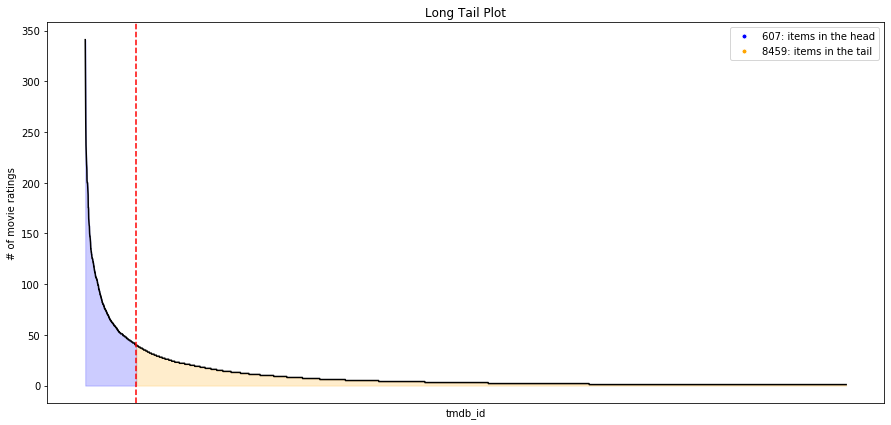

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
import seaborn as sns

reader = Reader()
ratings = pd.read_csv('data/themoviesdataset/ratings_small.csv')
#ratings = pd.read_csv('data/themoviesdataset/ratings_small.csv')
ratings['timestamp'] = ratings['timestamp'].apply( lambda x: datetime.fromtimestamp(x).date())
ratings.rename(columns = {'movieId':'tmdb_id'},inplace=True)
ratings.head()

fig = plt.figure(figsize=(15, 7))
long_tail_plot(df=ratings,
               item_id_column="tmdb_id",
               interaction_type="movie ratings",
               percentage=0.5,
               x_labels=False)

## Collaborative Filtering Recommender

In [95]:
#format data for surprise
# Surprise(Simple Python RecommendatIon System Engine)
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'tmdb_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [10]:
#train SVD recommender 
algo = SVD()
algo.fit(trainset)

In [98]:
#make predictions on test set. 
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
test.head()

,userId,movieId,actual,cf_predictions
0,15,1303,2.0,2.340967
1,654,236,4.0,3.983133
2,382,91886,4.0,3.161195
3,350,2890,4.0,3.936461
4,41,1220,5.0,4.523042


## MSE and RMSE

In [104]:
from sklearn.metrics import mean_squared_error

def mse(y, yhat):
    mse = mean_squared_error(y, yhat)
    return mse

def rmse(y, yhat):
    rmse = sqrt(mean_squared_error(y, yhat))
    return rmse

In [105]:
#evaluate model with MSE and RMSE
from math import sqrt
print(mse(test.actual, test.cf_predictions))
print(rmse(test.actual, test.cf_predictions))

0.5224652845187561
0.7228176011406723


## Collaborative Filtering

In [106]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)

In [107]:
cf_model

movieId,1,2,3,4,5,6,7,8,9,10,...,157407,159690,159858,159972,160271,160440,160563,160565,160590,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,3.35075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [67]:
#cf_model = cf_model.applymap(str)

In [109]:
cf_model.loc[1]

movieId
1         0.0
2         0.0
3         0.0
4         0.0
5         0.0
         ... 
160440    0.0
160563    0.0
160565    0.0
160590    0.0
163949    0.0
Name: 1, Length: 5358, dtype: float64

In [111]:
#format test data
test_series = test.copy().groupby('userId')['movieId'].agg(actual=(lambda x: list(set(x)))).reset_index()['actual']

In [112]:
#make recommendations for all members in the test data
cf_recs = [] = []
for user in test_series.index:
    cf_predictions = get_users_predictions(user+1, 10, cf_model)
    cf_recs.append(cf_predictions)

In [113]:
test_df = pd.DataFrame(test_series, columns = ['actual', 'cf_predictions'])
test_df['cf_predictions'] = cf_recs
test_df

,actual,cf_predictions
0,"[1263, 1339, 1172, 3671, 2105, 1371, 31]","[1172, 1263, 2105, 3671, 1339, 31, 1371, 7810,..."
1,"[261, 144, 273, 539, 550, 552, 300, 319, 457, ...","[720, 110, 457, 497, 261, 349, 364, 300, 144, ..."
2,"[2694, 267, 84236, 2959, 50068, 2716, 44191, 2...","[318, 296, 2959, 1197, 1235, 2762, 44191, 110,..."
3,"[2822, 903, 3210, 2699, 1674, 1805, 919, 3101,...","[2918, 903, 2788, 1198, 1240, 1259, 2144, 2005..."
4,"[1923, 4995, 3, 33166, 2706, 1307, 30749, 6942...","[33166, 2081, 30749, 3897, 4995, 4963, 6502, 4..."
...,...,...
666,"[292, 356, 41, 266, 300, 110, 1199, 272, 307, ...","[307, 1199, 356, 501, 272, 41, 110, 247, 300, ..."
667,"[296, 6425, 720]","[296, 720, 6425, 1, 7782, 7831, 7827, 7826, 78..."
668,"[2881, 1953, 3016, 4015, 785, 3863, 2396, 2174]","[2396, 1953, 785, 3016, 2174, 3863, 2881, 4015..."
669,"[608, 34, 1923, 2759, 2571, 2770]","[608, 2571, 34, 1923, 2759, 2770, 7757, 7802, ..."


In [114]:
popularity_recs = ratings.tmdb_id.value_counts().head(10).index.tolist()

### Popularity Recommender

In [115]:
#make recommendations for all members in the test data
popularity_recs = ratings.tmdb_id.value_counts().head(10).index.tolist()

pop_recs = []
for user in test_series.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test_df['pop_predictions'] = pop_recs
test_df.head()

,actual,cf_predictions,pop_predictions
0,"[1263, 1339, 1172, 3671, 2105, 1371, 31]","[1172, 1263, 2105, 3671, 1339, 31, 1371, 7810,...","[356, 296, 318, 593, 260, 480, 2571, 1, 527, 589]"
1,"[261, 144, 273, 539, 550, 552, 300, 319, 457, ...","[720, 110, 457, 497, 261, 349, 364, 300, 144, ...","[356, 296, 318, 593, 260, 480, 2571, 1, 527, 589]"
2,"[2694, 267, 84236, 2959, 50068, 2716, 44191, 2...","[318, 296, 2959, 1197, 1235, 2762, 44191, 110,...","[356, 296, 318, 593, 260, 480, 2571, 1, 527, 589]"
3,"[2822, 903, 3210, 2699, 1674, 1805, 919, 3101,...","[2918, 903, 2788, 1198, 1240, 1259, 2144, 2005...","[356, 296, 318, 593, 260, 480, 2571, 1, 527, 589]"
4,"[1923, 4995, 3, 33166, 2706, 1307, 30749, 6942...","[33166, 2081, 30749, 3897, 4995, 4963, 6502, 4...","[356, 296, 318, 593, 260, 480, 2571, 1, 527, 589]"


### Random Recommender

In [116]:
#make recommendations for all members in the test data

ran_recs = []
for user in test_series.index:
    random_predictions = ratings.tmdb_id.sample(10).values.tolist()
    ran_recs.append(random_predictions)
        
test_df['random_predictions'] = ran_recs
test_df.head()

,actual,cf_predictions,pop_predictions,random_predictions
0,"[1263, 1339, 1172, 3671, 2105, 1371, 31]","[1172, 1263, 2105, 3671, 1339, 31, 1371, 7810,...","[356, 296, 318, 593, 260, 480, 2571, 1, 527, 589]","[2523, 8947, 38798, 480, 357, 51662, 99114, 42..."
1,"[261, 144, 273, 539, 550, 552, 300, 319, 457, ...","[720, 110, 457, 497, 261, 349, 364, 300, 144, ...","[356, 296, 318, 593, 260, 480, 2571, 1, 527, 589]","[160, 1882, 4975, 898, 919, 800, 264, 3256, 10..."
2,"[2694, 267, 84236, 2959, 50068, 2716, 44191, 2...","[318, 296, 2959, 1197, 1235, 2762, 44191, 110,...","[356, 296, 318, 593, 260, 480, 2571, 1, 527, 589]","[1193, 8511, 3543, 741, 4979, 206, 2394, 2716,..."
3,"[2822, 903, 3210, 2699, 1674, 1805, 919, 3101,...","[2918, 903, 2788, 1198, 1240, 1259, 2144, 2005...","[356, 296, 318, 593, 260, 480, 2571, 1, 527, 589]","[3919, 5219, 260, 112552, 27904, 3264, 316, 17..."
4,"[1923, 4995, 3, 33166, 2706, 1307, 30749, 6942...","[33166, 2081, 30749, 3897, 4995, 4963, 6502, 4...","[356, 296, 318, 593, 260, 480, 2571, 1, 527, 589]","[596, 49957, 1225, 68838, 733, 109487, 5618, 9..."


### Recall

In [117]:
actual = test_df.actual.values.tolist()
cf_predictions = test_df.cf_predictions.values.tolist()
pop_predictions = test_df.pop_predictions.values.tolist()
random_predictions = test_df.random_predictions.values.tolist()

In [118]:
"""
Computes the average recall at k.
"""
def _ark(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / len(actual)

In [119]:
"""
Computes the mean average recall at k.
"""
def mark(actual, predicted, k=10):
    return np.mean([_ark(a,p,k) for a,p in zip(actual, predicted)])

In [120]:
import numpy as np
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([mark(actual, pop_predictions, k=K)])
pop_mark

[0.005004481274583573,
 0.009046464560470402,
 0.0115243583144317,
 0.013565070245334323,
 0.014935255971330084,
 0.01622791775378849,
 0.017423589352414382,
 0.018217095747630748,
 0.019070035988817777,
 0.019848767586987687]

In [122]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([mark(actual, random_predictions, k=K)])
random_mark

[0.0014085788964469709,
 0.001737071387358876,
 0.002023013218812417,
 0.002141822234876485,
 0.0023561834830999884,
 0.0025569024247794063,
 0.0026966150317588554,
 0.0027944529484446663,
 0.0028451680587885672,
 0.0029449604204396136]

In [121]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([mark(actual, cf_predictions, k=K)])
cf_mark

[0.07828402096557176,
 0.15656804193114351,
 0.23336174993099248,
 0.30369743507937597,
 0.3665815553991454,
 0.4229082986697345,
 0.4727770190888582,
 0.5141296654181373,
 0.5508250837295326,
 0.5833807438028091]

## Mean Average Recall @ K

In [123]:
"""
Plots the mean average recall at k for a set of models to compare.
"""
def mark_plot(mark_scores, model_names, k_range):
    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #lineplot
    mark_df = pd.DataFrame(np.column_stack(mark_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mark_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('Mean Average Recall at K (MAR@K) Comparison')
    ax.set_ylabel('MAR@K')
    ax.set_xlabel('K')

    plt.show()

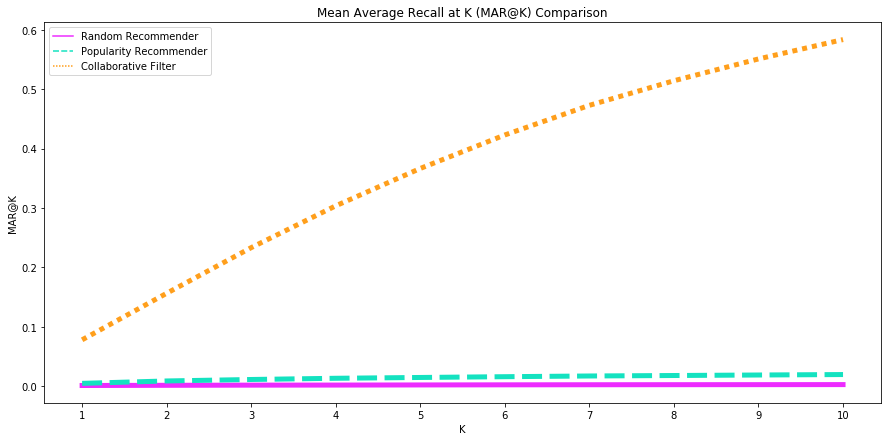

In [124]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
mark_plot(mark_scores, model_names=names, k_range=index)

## Mean Average Precision @ K

In [125]:
"""
Computes the average precision at k.
"""
def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

"""
Computes the mean average precision at k.
"""
def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [126]:
pop_mapk = []
for K in np.arange(1, 11):
    pop_mapk.extend([mapk(actual, pop_predictions, k=K)])

random_mapk = []
for K in np.arange(1, 11):
    random_mapk.extend([mapk(actual, random_predictions, k=K)])

cf_mapk = []
for K in np.arange(1, 11):
    cf_mapk.extend([mapk(actual, cf_predictions, k=K)])

In [127]:
"""
Plots the mean average precision at k for a set of models to compare.
"""
def mapk_plot(mapk_scores, model_names, k_range):
    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #lineplot
    mapk_df = pd.DataFrame(np.column_stack(mapk_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mapk_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('Mean Average Precision at K (MAP@K) Comparison')
    ax.set_ylabel('MAP@K')
    ax.set_xlabel('K')

    plt.show()

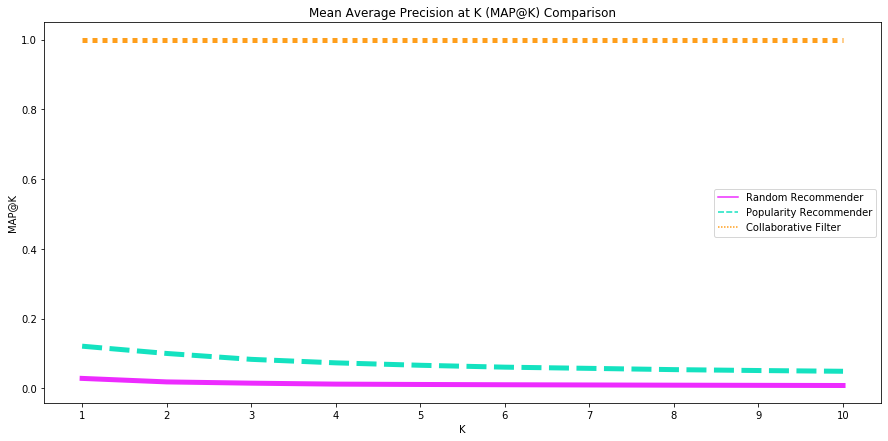

In [128]:
mapk_scores = [random_mapk, pop_mapk, cf_mapk]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
mapk_plot(mapk_scores, model_names=names, k_range=index)